## 按照时间维度对数据集进行切分

In [2]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## 先进行控制变量实验 验证模型的有效性

In [9]:
# 准备数据集
from utils import *

data_csv = pd.read_csv('../../csv/dataset_handled.csv')
data_ramdom = data_csv.sample(frac=1, random_state=1).reset_index(drop=True)

data_1 = data_ramdom[: 6929]
data_2 = data_ramdom[6929: 9597]
data_3 = data_ramdom[9597: ]
print(data_1.shape, data_2.shape, data_3.shape)

(6929, 9) (2668, 9) (3878, 9)


In [10]:
from collections import Counter
print(Counter(data_1['label']))
print(Counter(data_2['label']))
print(Counter(data_3['label']))

Counter({'virus': 1859, 'trojan': 1842, 'worm': 1761, 'backdoor': 1467})
Counter({'trojan': 732, 'virus': 700, 'worm': 677, 'backdoor': 559})
Counter({'virus': 1041, 'trojan': 1026, 'worm': 1021, 'backdoor': 790})


In [11]:
data_path_1, labels_1 = path_loader(data_1)
data_path_2, labels_2 = path_loader(data_2)
data_path_3, labels_3 = path_loader(data_3)

In [6]:
# 加载数据并进行训练
from tensorflow import keras
from tensorflow.keras import layers, optimizers, Sequential, metrics
from tensorflow.keras import Input, Model, regularizers
from malconv import get_malconv


batch_size = 128
db_train = tf.data.Dataset.from_generator(train_data_generator, args=[data_path_1, labels_1, 'train'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_train = db_train.batch(batch_size).repeat(9)

db_val = tf.data.Dataset.from_generator(train_data_generator, args=[data_path_1, labels_1, 'val'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_val = db_val.batch(batch_size).repeat(8)

model = get_malconv()
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=[keras.metrics.CategoricalAccuracy()])

history = model.fit(db_train,
                    epochs=7,
                    steps_per_epoch=46,
                    validation_data=db_val,
                    validation_steps=7)

Epoch 1/7
46/46 [==============================] - 632s 14s/step - loss: 1.8950 - categorical_accuracy: 0.5712 - val_loss: 0.9513 - val_categorical_accuracy: 0.8940
Epoch 2/7
46/46 [==============================] - 528s 12s/step - loss: 0.7953 - categorical_accuracy: 0.9345 - val_loss: 0.4965 - val_categorical_accuracy: 0.9732
Epoch 3/7
46/46 [==============================] - 535s 12s/step - loss: 0.4746 - categorical_accuracy: 0.9643 - val_loss: 0.3211 - val_categorical_accuracy: 0.9900
Epoch 4/7
46/46 [==============================] - 517s 11s/step - loss: 0.3168 - categorical_accuracy: 0.9830 - val_loss: 0.2337 - val_categorical_accuracy: 0.9967
Epoch 5/7
46/46 [==============================] - 481s 11s/step - loss: 0.2388 - categorical_accuracy: 0.9909 - val_loss: 0.1836 - val_categorical_accuracy: 0.9989
Epoch 6/7
46/46 [==============================] - 608s 13s/step - loss: 0.1835 - categorical_accuracy: 0.9964 - val_loss: 0.1540 - val_categorical_accuracy: 0.9989
Epoch 7/7


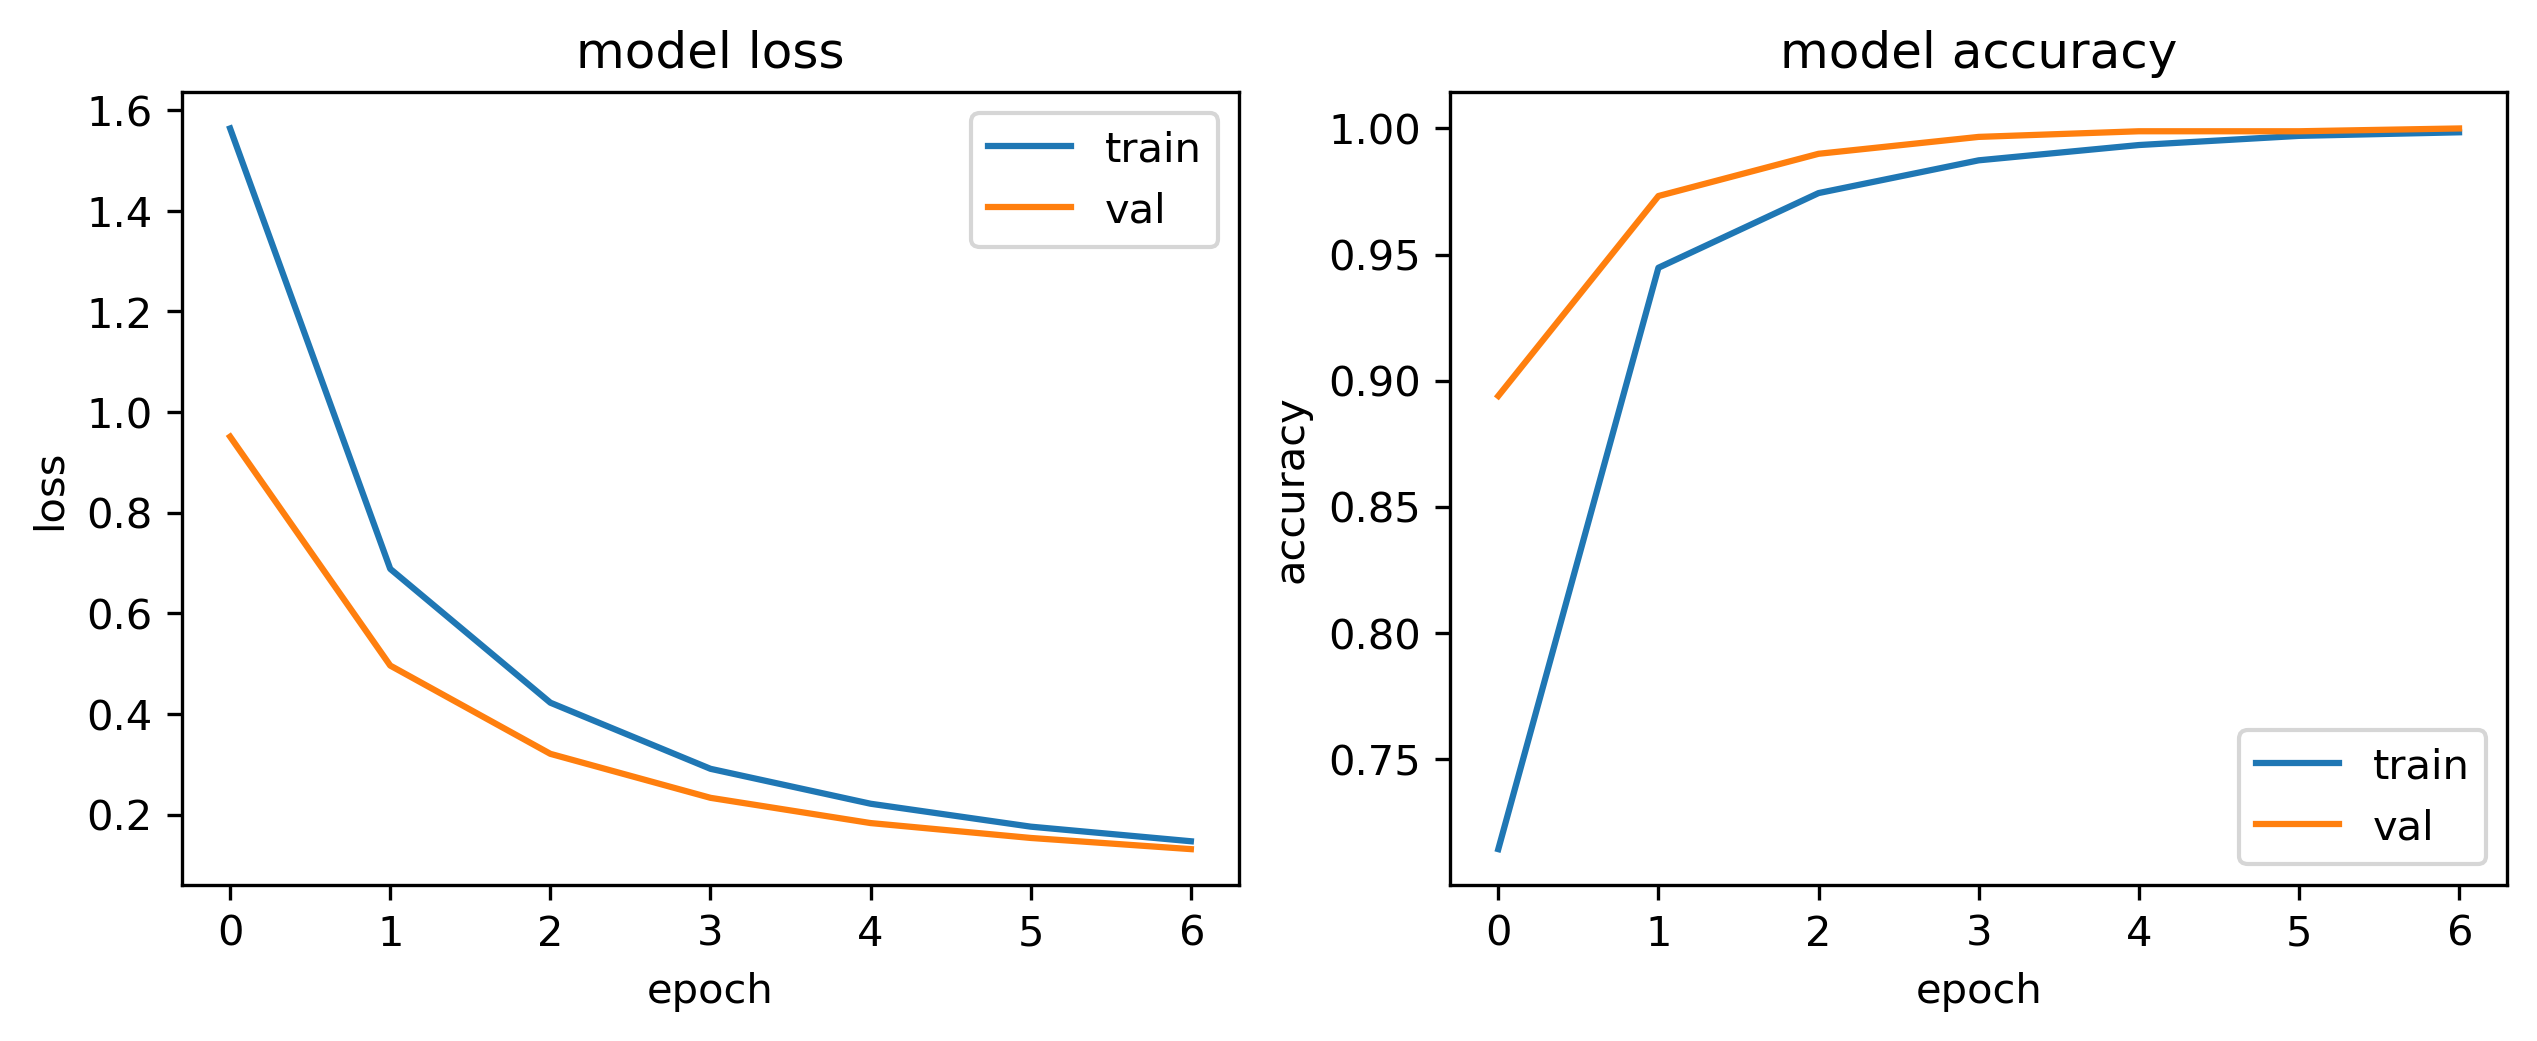

In [7]:
 # 绘制loss和acc曲线
def PlotLoss(model_name, history):
    
    p1 = plt.figure(figsize=(10, 3.5),dpi=300)
    ax1 = p1.add_subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train","val"],loc="upper right")

    ax2 = p1.add_subplot(1,2,2)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train","val"],loc="lower right")
    plt.savefig("./figures/" + model_name + '.png')
    
PlotLoss('malconv_random', history)

In [8]:
# 进行模型保存
model.save('../model/malconv_random.h5')

In [12]:
# 测试数据
from sklearn.metrics import classification_report
from tensorflow import keras
model = keras.models.load_model('../model/malconv_random.h5')
# 批量预测数据
batch_size = 100
for idx in range(0, len(data_path_2), batch_size):
    code_tmp, label_tmp = test_data_loader(data_path_2[idx:idx+batch_size], labels_2[idx:idx+batch_size])
    y_pred_tmp = model.predict(code_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_true_tmp = np.argmax(label_tmp, axis=1)
    y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis = 0)
    y_true = y_true_tmp if idx == 0 else np.concatenate((y_true, y_true_tmp), axis = 0)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

100%|██████████| 68/68 [00:02<00:00, 24.94it/s]
              precision    recall  f1-score   support

        worm     0.9536    0.9822    0.9677       732
      trojan     0.9769    0.9657    0.9713       700
    backdoor     0.9691    0.9719    0.9705       677
       virus     0.9834    0.9553    0.9691       559

    accuracy                         0.9696      2668
   macro avg     0.9707    0.9688    0.9697      2668
weighted avg     0.9699    0.9696    0.9696      2668



In [13]:
# 批量预测数据
batch_size = 100
for idx in range(0, len(data_path_3), batch_size):
    code_tmp, label_tmp = test_data_loader(data_path_3[idx:idx+batch_size], labels_3[idx:idx+batch_size])
    y_pred_tmp = model.predict(code_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_true_tmp = np.argmax(label_tmp, axis=1)
    y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis = 0)
    y_true = y_true_tmp if idx == 0 else np.concatenate((y_true, y_true_tmp), axis = 0)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

100%|██████████| 78/78 [00:02<00:00, 29.75it/s]
              precision    recall  f1-score   support

        worm     0.9378    0.9844    0.9605      1026
      trojan     0.9788    0.9741    0.9764      1041
    backdoor     0.9849    0.9559    0.9702      1021
       virus     0.9767    0.9570    0.9668       790

    accuracy                         0.9685      3878
   macro avg     0.9695    0.9678    0.9685      3878
weighted avg     0.9691    0.9685    0.9686      3878



In [8]:
# 训练数据
from sklearn.metrics import classification_report
from tensorflow import keras
model = keras.models.load_model('../model/malconv_random.h5')

# 批量预测数据
batch_size = 100
for idx in range(0, len(data_path_1), batch_size):
    code_tmp, label_tmp = test_data_loader(data_path_1[idx:idx+batch_size], labels_1[idx:idx+batch_size])
    y_pred_tmp = model.predict(code_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_true_tmp = np.argmax(label_tmp, axis=1)
    y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis = 0)
    y_true = y_true_tmp if idx == 0 else np.concatenate((y_true, y_true_tmp), axis = 0)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=6))

100%|██████████| 29/29 [00:00<00:00, 41.44it/s]
              precision    recall  f1-score   support

        worm     1.0000    0.9995    0.9997      1842
      trojan     0.9995    0.9995    0.9995      1859
    backdoor     0.9994    0.9994    0.9994      1761
       virus     0.9993    1.0000    0.9997      1467

    accuracy                         0.9996      6929
   macro avg     0.9996    0.9996    0.9996      6929
weighted avg     0.9996    0.9996    0.9996      6929

